<a href="https://colab.research.google.com/github/elyesaseidel/motion-to-emotion/blob/main/Justin/Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import 

In [1]:
# !pip install SpeechRecognition
# !pip install streamlit -q
# !pip install pyngrok
# # !pip install ffmpeg-python
# !pip install python-settings
# !pip install synthesizer
# # !pip install inference
# # !pip install helper
# !pip install SpeechRecognition moviepy
# # !pip3 install imageio==2.4.1
# # !pip install imageio-ffmpeg
# !pip install --upgrade moviepy
# # !pip install aspect-based-sentiment-analysis==1.1.0
# !pip install deepface
# !pip install nltk
# !pip install neattext
# !pip install librosa

import neattext.functions as nfx
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from deepface import DeepFace 
from collections import Counter
from pathlib import Path
import os
import glob
import cv2
import pickle
# import aspect_based_sentiment_analysis as absa
from pyngrok import ngrok
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
import speech_recognition as sr
from google.colab import output
from base64 import b64decode
import base64
# from google.colab.output import eval_js
# from IPython.display import HTML, Javascript


# https://ngrok.com/ to sign in for free to get auth_key 
# Tutorial to run streamlit on colab
# https://www.youtube.com/watch?v=MUD-pBOnvdo 
ngrok.set_auth_token('2LC761bNPuCZchtb90lWWFD5sor_G1ecaAUAsAYDSjp6FTD5')

# mount your drive with colab notebook
drive.mount('/content/gdrive')

# # how to read data from google drive
# df = pd.read_csv('/content/gdrive/MyDrive/From Motion to Emotion/testing.csv')
# # save data to google drive
# path = '/content/gdrive/MyDrive/From Motion to Emotion/output.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   df_alt.to_csv(f)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Streamlit code

Video resourse \
https://www.youtube.com/watch?v=y9Trdafp83U ('There's more to life than being happy | Emily Esfahani Smith') \
https://www.youtube.com/watch?v=KAJsdgTPJpU&t=1s ('Greta Thunberg's full speech to world leaders at UN Climate Action Summit')\
https://www.youtube.com/watch?v=wD2cVhC-63I ('Matthew McConaughey winning Best Actor | 86th Oscars (2014)')

In [152]:
%%writefile Motion_to_Emotion.py 
import streamlit as st 
from pyngrok import ngrok
from google.colab import drive
from google.colab import files
from google.colab import output
import pandas as pd
import speech_recognition as sr
import base64
from base64 import b64decode
import cv2
from deepface import DeepFace 
from collections import Counter
from pathlib import Path
import pickle
import os
import glob
from collections import Counter
from PIL import Image
import moviepy.editor as mp
r = sr.Recognizer()
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
import numpy as np
import neattext.functions as nfx
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
import librosa
import librosa.display
import matplotlib.pyplot as plt


image = Image.open('/content/gdrive/MyDrive/From Motion to Emotion/emotion_imgage.jpeg')
st.image(image)#, caption='Sunrise by the mountains')

st.title('Motion to Emotion')



option = st.selectbox(
    'Select a video to analyse',
    ('Choose video',
    'Greta Thunberg\'s speech at UN', 
    'Emily Esfahani Smith - There\'s more to life than being happy', 
    'Matthew McConaughey winning Best Actor 86th Oscars (2014)'))


if option == 'Greta Thunberg\'s speech at UN':
  path = '/content/gdrive/MyDrive/From Motion to Emotion/Greta_UN.mp4'
  #st.subheader('Greta Thunberg\'s speech at UN')
  st.video(path)

if option == 'Emily Esfahani Smith - There\'s more to life than being happy':
  path = '/content/gdrive/MyDrive/From Motion to Emotion/Emily_Happy.mp4'
  #st.subheader('Emily Esfahani Smith - There\'s more to life than being happy')
  st.video(path)

if option == 'Matthew McConaughey winning Best Actor 86th Oscars (2014)':
  path = '/content/gdrive/MyDrive/From Motion to Emotion/Matthew_Oscars.mp4'
  #st.subheader('Matthew McConaughey winning Best Actor 86th Oscars (2014)')
  st.video(path)



if st.button('Start Analysis'):

# Speech Recognition 
    
  clip = mp.VideoFileClip(path) 
  clip.audio.write_audiofile('audio.wav')

  audio = sr.AudioFile("audio.wav")

  with audio as source:
    audio_file = r.record(source)
    text = r.recognize_google(audio_file)


# Face emotion dectection 
# Extrac frames from video 
  video = cv2.VideoCapture(path)
      
  total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

  step = 30 # if step = 10, then only every 10-th frame will be considered and saved

  from collections import Counter
  count = 0

  frame_list = [] 

  for i in range(total_frames):
      ret, frame = video.read()
      if ret:
          count += 1
          if count % step == 0:
              frame_list.append(frame)
              
  video.release()

# Analysis emotion from frames

  df = pd.DataFrame()
  emotions_list = []

  for picture in frame_list:
    objs = DeepFace.analyze(picture, actions = 'emotion', enforce_detection = False)
    dominant_emotion = objs[0]['dominant_emotion']
    emotions_list.append(dominant_emotion)

# Create datafram from the output

  df['Emotion'] = Counter(emotions_list).keys()
  df['Counts'] = Counter(emotions_list).values()
  df['Percentage'] = (df['Counts']/df['Counts'].sum())*100
    
  df_sorted = df[['Emotion','Percentage']].sort_values(by = 'Percentage', ascending=False)
  df_sorted.reset_index(drop = True, inplace=True)

#emoton emoji dictionary

  emoji_dic = {'neutral': ':neutral_face:',
            'fear':':anguished:',
            'angry': ':angry:',
            'sad':':cry:',
            'happy':':grin:',
            'suprise':':astanished:',
            'disgust':':confounded:'
            }
  
  text_sent = {'neg' : 'Negative',
              'neu' : 'Neutral',
              'pos' : 'Positive' 
              }
  
  text_emo = {'joy' : 'Happy',
              'sadness' : 'Sad',
              'fear' : 'Fear',
              'anger' : 'Angry',
              'suprise' : 'Surprise',
              'neutral' : 'Neutral',
              'disgust' : 'Disgust'
              }

  
# Result displaying 

  with st.container():
    st.header(':blue[Speech Recognition]')
    st.write(text)

# Text sentiment analysis 
    sentiment = sia.polarity_scores(text)
    keys_to_keep = ['neg', 'neu', 'pos']
    sentiment = {k: sentiment[k] for k in keys_to_keep}
    st.header(':blue[Sentiment of the Text]')
    st.subheader(text_sent[max(sentiment, key=sentiment.get)])


# Text Emotion analysis

    st.header(':blue[Emotion of the Text]')
    loaded_model = pickle.load(open('emo_text_model.sav', 'rb'))
    emo_predict = loaded_model.predict([text])[0]
    st.subheader(text_emo[emo_predict])

  with st.container():
    st.header(":blue[Face Emotion]")
    col1, col2, col3 = st.columns(3)
    
    with col1:
      st.subheader('Most domiant')
      st.subheader(df_sorted.Emotion[0])
      st.subheader(emoji_dic[df_sorted.Emotion[0]])
      st.subheader(df_sorted.Percentage[0].round(2))

    with col2:
      st.subheader('2nd')
      st.subheader(df_sorted.Emotion[1])
      st.subheader(emoji_dic[df_sorted.Emotion[1]])
      st.subheader(df_sorted.Percentage[1].round(2))

    with col3:
      st.subheader('3rd')
      st.subheader(df_sorted.Emotion[2])
      st.subheader(emoji_dic[df_sorted.Emotion[2]])
      st.subheader(df_sorted.Percentage[2].round(2))

    with st.container():
      st.header(':blue[Spectrogram of the voice]')
      y, sr = librosa.load('audio.wav')
      y, index = librosa.effects.trim(y)  
      mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
      mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
      spectrogram = librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');
      spectrogram 



Overwriting Motion_to_Emotion.py


# Get Ngrok tunnel and connect

In [7]:
# get tunnel 
!nohup streamlit run Motion_to_Emotion.py --server.port 80 &
url = ngrok.connect(port = '80')
print(url)

nohup: appending output to 'nohup.out'
NgrokTunnel: "http://dd1c-34-125-222-11.ngrok.io" -> "http://localhost:80"


# Audio recording 

In [ ]:
# js = Javascript("""
#   async function recordAudio(){
#     const div = document.createElement('div');
#     const audio = document.createElement('audio');
#     const strtButton = document.createElement('button');
#     const stopButton = document.createElement('button');

#     strtButton.textContent = 'Start Recording';
#     stopButton.textContent = 'Stop Recording';

#     document.body.appendChild(div);
#     div.appendChild(strtButton);
#     div.appendChild(audio);

#     const stream = await navigator.mediaDevices.getUserMedia({audio:true});
#     let recorder = new MediaRecorder(stream);

#     audio.style.display = 'block';
#     audio.srcObject = stream;
#     audio.controls = true;
#     audio.muted = true;

#     await new Promise((resolve) => strtButton.onclick = resolve);
#       strtButton.replaceWith(stopButton);
#       recorder.start();

#     await new Promise((resolve) => stopButton.onclick = resolve);
#       recorder.stop();
#       let recData = await new Promise ((resolve) => recorder.ondataavailable = resolve);
#       let arrBuff = await recData.data.arrayBuffer();
#       stream.getAudioTracks()[0].stop();
#       div.remove()
      
#       let binaryString = '';
#       let bytes = new Uint8Array(arrBuff);
#       bytes.forEach((byte) => { binaryString += String.fromCharCode(byte)});

#     const url = URL.createObjectURL(recData.data);
#     const player = document.createElement('audio');
#     player.controls = true;
#     player.src = url;
#     document.body.appendChild(player);
  
#   return btoa(binaryString)};
#   """)

In [ ]:
# # Record audio
# display(js)
# output = eval_js('recordAudio({})')
# with open ('audio.wav','wb') as file:
#     binary = base64.b64decode(output)
#     file.write(binary)
# print('Recording saved to:', file.name)

# DeepFace Emotion Detection

In [ ]:
# Open the video file from a folder 
video = cv2.VideoCapture('/content/gdrive/MyDrive/From Motion to Emotion/Greta_UN.mp4')
    
# Get the total number of frames in the video
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Set the step
step = 10 # if step = 10, then only every 10-th frame will be considered and saved

# Initialize the counter
from collections import Counter
count = 0

frame_list = [] 
# Iterate over each frame
for i in range(total_frames):
    ret, frame = video.read()
    if ret:
        count += 1
        if count % step == 0:
            frame_list.append(frame)
            #cv2.imwrite('/content/gdrive/MyDrive/From Motion to Emotion/picture/frame{}.jpg'.format(i), frame)
video.release()

In [ ]:
# from IPython.display import JSON #uncomment in case of an error
from deepface import DeepFace # to work with faces
from collections import Counter
from pathlib import Path
import os
import glob
from collections import Counter

df = pd.DataFrame()
list_frames_emotions = []

# video_frames_path = Path('/content/gdrive/MyDrive/From Motion to Emotion/picture')

# os.chdir(video_frames_path)

# video_frames = glob.glob("./*")

for picture in frame_list:

    objs = DeepFace.analyze(picture, actions = 'emotion', enforce_detection = False)
    dominant_emotion = objs[0]['dominant_emotion']
    list_frames_emotions.append(dominant_emotion)

df['Emotion'] = Counter(list_frames_emotions).keys()
df['Counts'] = Counter(list_frames_emotions).values()
df['Percentage'] = (df['Counts']/df['Counts'].sum())*100
print(df)
print(df[df.Percentage == df.Percentage.max()])


Action: emotion:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: ignored

In [ ]:
# most domiant emotion of the face expression
print(df[df.Percentage == df.Percentage.max()])

## Video-Frame-DeepFace-Output (One Code)

In [ ]:
# !pip install deepface
import cv2
from deepface import DeepFace 
from collections import Counter
from pathlib import Path
import os
import glob
from collections import Counter

# Extrac frames from video 
video = cv2.VideoCapture('/content/gdrive/MyDrive/From Motion to Emotion/Greta_UN.mp4')
    
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

step = 10 # if step = 10, then only every 10-th frame will be considered and saved

from collections import Counter
count = 0

frame_list = [] 

for i in range(total_frames):
    ret, frame = video.read()
    if ret:
        count += 1
        if count % step == 0:
            frame_list.append(frame)
            
video.release()

# Analysis emotion from frames

df = pd.DataFrame()
emotions_list = []

for picture in frame_list:

    objs = DeepFace.analyze(picture, actions = 'emotion', enforce_detection = False)
    dominant_emotion = objs[0]['dominant_emotion']
    emotions_list.append(dominant_emotion)

# Create Output
df['Emotion'] = Counter(emotions_list).keys()
df['Counts'] = Counter(emotions_list).values()
df['Percentage'] = (df['Counts']/df['Counts'].sum())*100
print(df)
print(df[df.Percentage == df.Percentage.max()])


In [ ]:
df

In [ ]:
percent = df.Percentage.max().round(2)
print (percent, '%')

In [ ]:
df_sorted = df[['Emotion','Percentage']].sort_values(by = 'Percentage', ascending=False)
df_sorted.reset_index(drop = True, inplace=True)

In [ ]:
emo_dic = {'neutral': ':neutral_face:',
           'fear':':anguished:',
           'angry': ':angry:',
           'sad':':cry:',
           'happy':':grin:',
           'suprise':':astanished:',
           'disgust':':confounded:' 
}


# Extract Text from Video

In [ ]:
# !pip install imageio-ffmpeg
import speech_recognition as sr
from moviepy.audio.AudioClip import AudioClip
from moviepy.audio.io.readers import FFMPEG_AudioReader

In [ ]:
audioclip = AudioFileClip('/content/gdrive/MyDrive/From Motion to Emotion/Greta_UN.mp4')
# audioclip.write_audiofile(f"audio_from_video_sm.wav")
# audio_to_be_text = (f"audio_from_video_sm.wav")

In [ ]:
r = sr.Recognizer()

# open the file
with sr.AudioFile(audio_to_be_text) as source:
    # listen for the data (load audio to memory)
    audio_data = r.record(source)
    # recognize (convert from speech to text)
    text = r.recognize_google(audio_data)
    print(text)

## new approach

In [ ]:
!pip install SpeechRecognition moviepy
!pip3 install imageio==2.4.1
!pip install imageio-ffmpeg
!pip install --upgrade moviepy
import speech_recognition as sr 
import moviepy.editor as mp
r = sr.Recognizer()

In [ ]:
clip = mp.VideoFileClip('/content/gdrive/MyDrive/From Motion to Emotion/Greta_UN.mp4') 
clip.audio.write_audiofile('Greta_UN.wav')

audio = sr.AudioFile("Greta_UN.wav")

with audio as source:
  audio_file = r.record(source)
  result = r.recognize_google(audio_file)

result

In [ ]:
audio = sr.AudioFile("conveGreta_UNrted.wav")

In [ ]:
with audio as source:
  audio_file = r.record(source)
  result = r.recognize_google(audio_file)

In [ ]:
result

In [ ]:
# exporting the result 
with open('recognized.txt',mode ='w') as file: 
   file.write("Recognized Speech:") 
   file.write("\n") 
   file.write(result) 
   print("ready!")

## 2 new approach

In [ ]:
from tkinter import *
import moviepy.editor as mp 
import speech_recognition as sr


root=Tk()
root.geometry('750x420+480+0')
root.resizable(False,False)
root.config(bg='dark slate gray')
root.title('Video To Text Converter')

def convert():
    clip = mp.VideoFileClip(entry_vid.get()) 
    clip.audio.write_audiofile(entry_file.get()) 
        
def text():
    r = sr.Recognizer()
    audio = sr.AudioFile(entry_file.get())
    with audio as source:        
        audtext = r.listen(source)
        try:            
            text1 = r.recognize_google(audtext)
            st1.set(text1)
        except:
            st1.set('Try Again!')
   
def EXIT():
    root.destroy()
     
    


# Ltitle = Label(root,text='Video to Text Converter',font='Courier 16 underline bold',bg='dark slate gray',fg='mint cream').grid(row=0,column=2,ipadx=70)

# Lvid = Label(root,text="Video Path :",font='Constantia 14',bg='dark slate gray',fg='mint cream').grid(row=2,column=1,ipady=24,ipadx=18)
# entry_vid = Entry(root,width=70)
# entry_vid.insert(0,"FILE PATH .mp4")
# entry_vid.place(x=150,y=60)
# btn_con = Button(root,text='Convert to Text',font='Constantia 10',fg='maroon',command=convert).place(x=600,y=55)

# Lfile = Label(root,text='File Name :',font='Constantia 14',bg='dark slate gray',fg='mint cream').grid(row=3,column=1,ipady=8,ipadx=18)
# entry_file = Entry(root,width=70)
# entry_file.insert(0,"FILE NAME .wav")
# entry_file.place(x=150,y=120)

# st1 =StringVar()
# Ltext = Label(root,text="Text :",font='Constantia 14',bg='dark slate gray',fg='mint cream').grid(row=4,column=1)
# entry_text = Entry(root,width=70,textvariable=st1).grid(row=4,column=2,ipady=85)
# btn_text = Button(root,text='Get Text',font='Constantia 10',command=text,fg='maroon').place(x=300,y=360)


# butexit = Button(root,text= "Exit",command=EXIT,font='Constantia 10',fg='maroon').place(x=380,y=360)


# root.mainloop()

               
  

# Aspect-Based Sentiment Analysis(ABSA)

In [5]:
# !pip install aspect-based-sentiment-analysis
# !pip uninstall aspect-based-sentiment-analysis==1.1.0
# import aspect_based_sentiment_analysis as absa

In [ ]:
# nlp = absa.load() 
# text_1 = ("this is all wrong I shouldn't be up here I should be back in school on the other side of the ocean yet you all come to us young people for Hope how dare you you have stolen my dreams and my childhood with your empty words and yet I'm one of the lucky ones people are suffering people are dying entire ecosystems are collapsing we are in the beginning of a mass extinction and all you can talk about is the money and fairy tales of Eternal economic growth how dare you")
# people, childhood, ecosystem  = nlp(text_1, aspects = ['people','childhood','ecosystem'])
# print(people.sentiment)
# print(childhood.sentiment)
# print(ecosystem.sentiment)

In [ ]:
# print("people", people.sentiment)
# print("dreams", dreams.sentiment)
# print("childhood", childhood.sentiment)
# print("ecosystem", ecosystem.sentiment)
# print("mass exstinction", mass_extinction.sentiment)
# print("fairy tales", fairy_tales.sentiment)
# print("ecnonomic growth", economic_growth.sentiment)

In [ ]:
# # importance 
# completed_task = nlp(text_3, aspects=['happiness', 'success', 'job', 'boyfriend', 'apartment', 'feeling', 'friends'])
# happiness, success, job, boyfriend, apartment, feeling, friends = completed_task.examples

# absa.summary(happiness)
# absa.display(happiness.review)

# absa.summary(success)
# absa.display(success.review)

# absa.summary(job)
# absa.display(job.review)

# absa.summary(boyfriend)
# absa.display(boyfriend.review)

# absa.summary(apartment)
# absa.display(feeling.review)

# absa.summary(friends)
# absa.display(friends.review)

# Simply Sentiment Analysis

In [144]:
text_sent = {'neg' : 'Negative',
              'neu' : 'Neutral',
              'pos' : 'Positive' 
              }

In [13]:
# # !pip install nltk
# import nltk
# nltk.download('vader_lexicon')
# from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

sentiment = sia.polarity_scores('It is beutiful day')
sentiment

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [23]:
keys_to_keep = ['neg', 'neu', 'pos']
sentiment = {k: sentiment[k] for k in keys_to_keep}
#print(max(sentiment, key=sentiment.get))
print(text_emo[max(sentiment, key=sentiment.get)])

Neutral Sentiment


# Text Emotion Detection 

In [126]:
# !pip install neattext
import pandas as pd
import numpy as np
import neattext.functions as nfx
# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Transformers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.pipeline import Pipeline

df = pd.read_csv("/content/gdrive/MyDrive/From Motion to Emotion/6_emotion.csv")
#df['Emotion'].value_counts()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## With stop_words

In [135]:
df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)

Xfeatures = df['Clean_Text']
ylabels = df['Emotion']

# split data
x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

# LogistiticRegression pipeline
pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

# train and fit data
pipe_lr.fit(x_train,y_train)

# with remove_userhandles
print(pipe_lr.score(x_test,y_test))

print(pipe_lr.predict([text])[0])

0.6323050392795555
anger


In [138]:
import pickle

filename = 'emo_text_model.sav'
pickle.dump(pipe_lr, open(filename, 'wb'))

In [139]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict([text])[0]
print(result)

anger


## Without stop_words 

In [134]:
# df['Clean_Text'] = df['Text'].apply(nfx.remove_userhandles)
# df['Clean_Text'] = df['Clean_Text'].apply(nfx.remove_stopwords)

# Xfeatures = df['Clean_Text']
# ylabels = df['Emotion']

# # split data
# x_train,x_test,y_train,y_test = train_test_split(Xfeatures,ylabels,test_size=0.3,random_state=42)

# # LogistiticRegression pipeline
# pipe_lr = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression())])

# # train and fit data
# pipe_lr.fit(x_train,y_train)

# # with remove_userhandles
# print(pipe_lr.score(x_test,y_test))

# print(pipe_lr.predict([text])[0])

0.6200421536692853
fear


### Text

In [132]:
# without stop words
nfx.remove_stopwords(text)

"wrong school ocean come young people Hope dare stolen dreams childhood words I'm lucky ones people suffering people dying entire ecosystems collapsing beginning mass extinction talk money fairy tales Eternal economic growth dare"

In [ ]:
# original text
text

"this is all wrong I shouldn't be up here I should be back in school on the other side of the ocean yet you all come to us young people for Hope how dare you you have stolen my dreams and my childhood with your empty words and yet I'm one of the lucky ones people are suffering people are dying entire ecosystems are collapsing we are in the beginning of a mass extinction and all you can talk about is the money and fairy tales of Eternal economic growth how dare you"

In [133]:
# without userhadles
nfx.remove_userhandles(text)

"this is all wrong I shouldn't be up here I should be back in school on the other side of the ocean yet you all come to us young people for Hope how dare you you have stolen my dreams and my childhood with your empty words and yet I'm one of the lucky ones people are suffering people are dying entire ecosystems are collapsing we are in the beginning of a mass extinction and all you can talk about is the money and fairy tales of Eternal economic growth how dare you"

# Audio to Spectrom

In [ ]:
# !pip install librosa

matplotlib.collections.QuadMesh

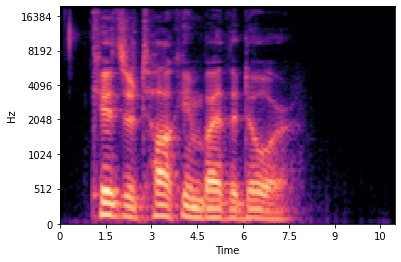

In [173]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
# path_save = r'C:\Users\Olia\Desktop\Lips Reading\Day5(Video+Audio_camera, CPU)\CNN_Checkpoints\test_spec.jpeg'
path_load = '/content/gdrive/MyDrive/From Motion to Emotion/03-01-01-01-01-01-01.wav'
y, sr = librosa.load(path_load)
y, index = librosa.effects.trim(y)
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
spectrogram = librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time');
# plt.savefig(path_save)
spectrogram